# Exploratory Data Analysis (EDA)

In this notebook, we attempt to study a classification problem by hand, and through automation (machine learning).
The data use for this problem is the salary classification problem - to see if we can classify whether individuals earn (<=50k, >50k) based on attributes such as: Occupation, Education, Age, Capital-gain, etc.. Summarily, we find that we attempt a manual-based decision tree approach to solving the problem. 

Whilst the *covariance/correlation* of two random variables is useful to determine whether variables have a funtional relationship, we present the *polarity/polarization* of two random variables as a measure of their seperation with respect to some class attribute - i.e. how far apart are points of a partiular class away from points of another class in Euclidean space. Unfortunately for this problem, neither metrics proved useful.

The dataset for this problem is obtainable from the UCI Machine Learning Repository (https://archive.ics.uci.edu/ml/datasets/Adult).

Note, whilst we have plotted the graphs inline, they are quite unsatisfactory. Therefore we advice changing the plots to be window-based allowing full-screening and zooming in. To do this, in the import section below, change '**%matplotlib notebook'** to '**%matplotlib tk'**', and you will probably need to restart the kernel aswell. **Note that the dataset needed is not included (due to the file size being too large) and you will have to download the dataset using the link above as well to run this.**


## Preliminaries (Imports and function definitions)

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns

# for jupyter:
import sys
sys.path.append('..')

from classification_funcs.classification_plots import create_dummy_matrix, create_classification_plots, create_andrews_plot, \
    create_rel_polarity_matrix, create_quantitative_mekko_charts, create_qualitative_mekko_charts

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:65% !important; }</style>"))

%matplotlib notebook

In [2]:
def data_preparation(datafile):
    df = pd.read_csv(datafile)

    # step: remove rows that have unknowns (cells with '?')
    unknown_mask = (df.T != '?').all()
    df = df[unknown_mask]

    return df

## Start of Analysis

In [3]:
df = data_preparation('adult.csv')

df_qual = df.select_dtypes(exclude=np.number)
df_quant = df.select_dtypes(include=np.number)

# For EDA, we not need to remove the last dummy category, but should this be an issue if we do?
df_dummies = create_dummy_matrix(df_qual) 

# change 'Salary' to dummy variable (less than 50K).
y_variable = pd.get_dummies(df['Salary'], prefix='Salary', prefix_sep=': ')['Salary: <=50K']

### Andrew curves

Andrew curves can be used as a quick way to find discriminants.

<IPython.core.display.Javascript object>


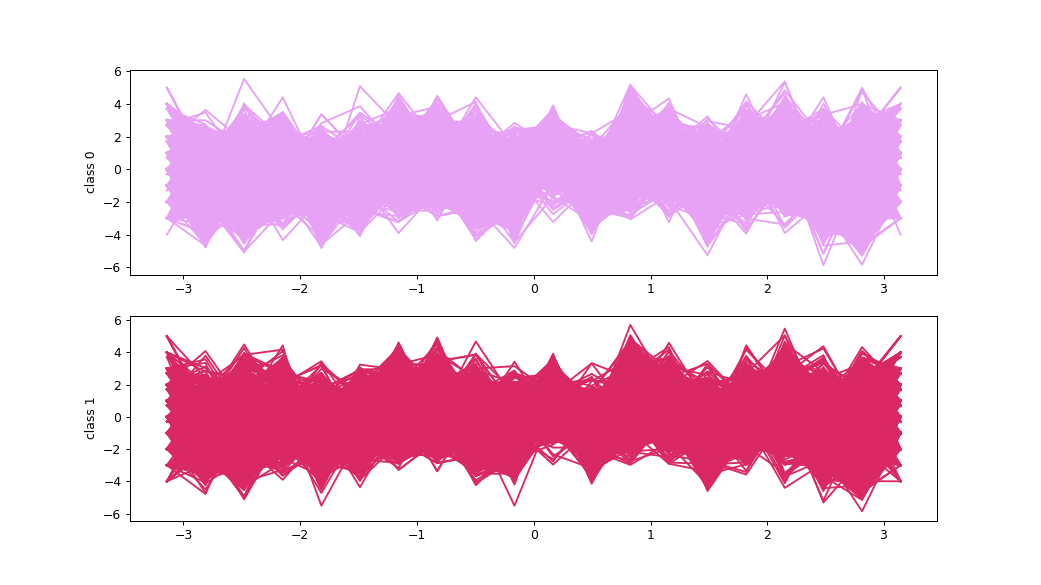

In [4]:
# use all variables (with categoricals translated to dummies)
create_andrews_plot(df_dummies,y_variable,num_samples=2000)

<IPython.core.display.Javascript object>


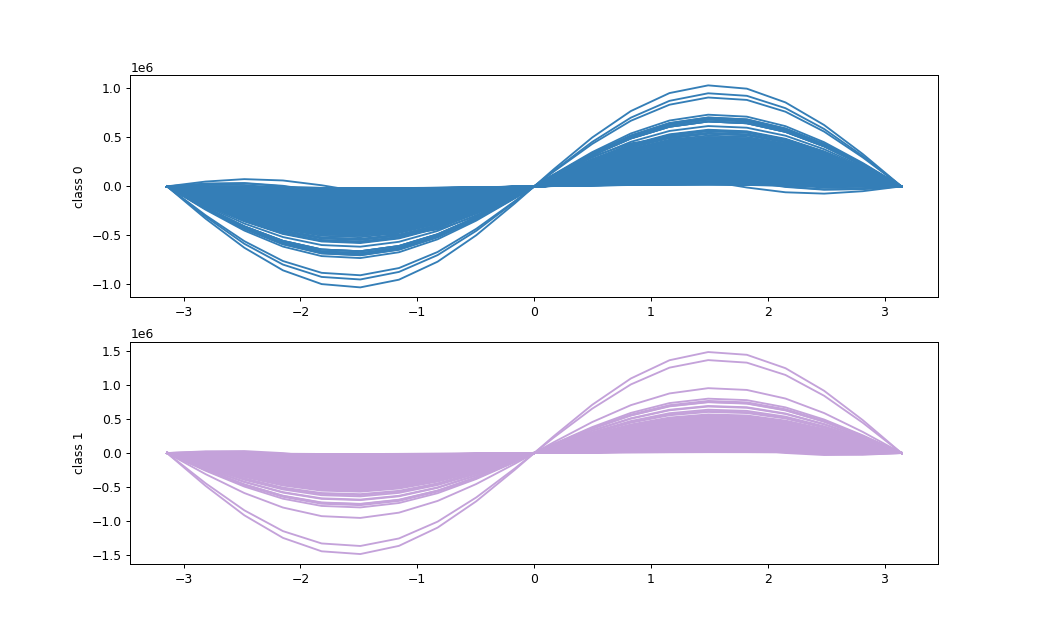

In [5]:
# use just the quantitative variables
create_andrews_plot(df_quant,y_variable,num_samples=2000)

The curves above do not unfortunately show a way to discriminate between the two classes (with class 1 being <=50k and class 0 being >50k). Therefore we will have to press further. Note that the plots are sensitive to the order of the variables. However based on the few different orderings we have tried, we were not able to find any that yielded a difference between the plots of each class.

## Exploring the quantitative variables alone

### R^2 values and polarity values

The correlation between a dummy (dichotomous variable - in this case the response variable y) and a quantitative variable may help us in classification. Let us determine the R^2 values (or coefficient of determination [in the case of bivariate regression]).

In [6]:
df_quant_r2 = (pd.concat([df_quant, y_variable], axis=1).corr() ** 2).sort_values(by=['Salary: <=50K'],
                                                                                      ascending='True')
df_quant_r2['Salary: <=50K']

Fnlwgt            0.000080
Capital-loss      0.022516
Capital-gain      0.048928
Hours-per-week    0.052661
Age               0.058563
Education-num     0.112417
Salary: <=50K     1.000000
Name: Salary: <=50K, dtype: float64

There appears to be no strong correlation between the quantative variables and *Salary*. Let us study the the relative polarity next:

In [7]:
# substep: see if polarity exists between quant. variables
rel_polarity_matrix = create_rel_polarity_matrix(df_quant, y_variable, classes=[1, 0])
rel_polarity_matrix

,Age,Fnlwgt,Education-num,Capital-gain,Capital-loss,Hours-per-week
Age,0.273738,0.000437,0.279894,0.121386,0.080993,0.257479
Fnlwgt,0.000437,0.000437,0.000437,0.001727,0.000439,0.000437
Education-num,0.279894,0.000437,0.406135,0.121385,0.080849,0.247548
Capital-gain,0.121386,0.001727,0.121385,0.121385,0.121302,0.121386
Capital-loss,0.080993,0.000439,0.080849,0.121302,0.080837,0.080946
Hours-per-week,0.257479,0.000437,0.247548,0.121386,0.080946,0.238539


The values of the matrix above indicates that there does not exist much polarity except between Education-num and itself. We can try to see if this is true via the scatterplots below.

### 2D scatterplots

<IPython.core.display.Javascript object>


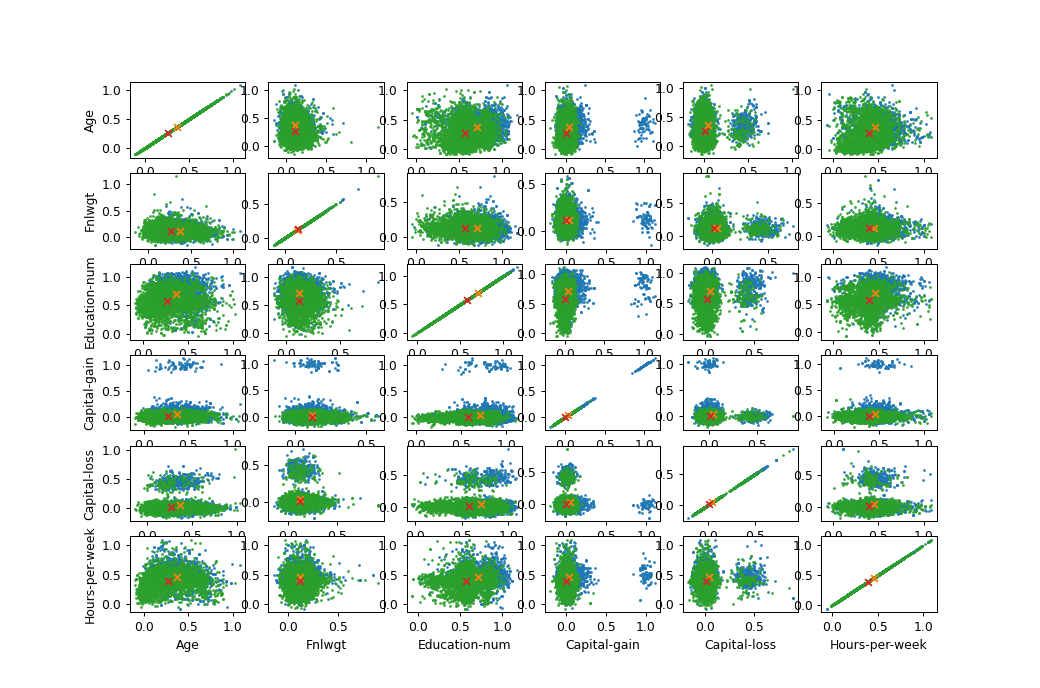

In [8]:
create_classification_plots(df_quant.copy(), y_variable, jitter=True, num_samples=4000, jitter_size=0.05,hide_legend=True)
plt.show()

In the diagram above, the blue dots represent samples of individuals where the salary was (> 50k), and the green are for (<= 50k). The two crosses represent the means, with orange being for (> 50k), and red for (<= 50k). 

Note firstly that the images can be misleading since we have chosen to plot only 4000 samples per class. This is not entirely appropriate since there are roughly 22000 rows for the (<= 50k) class whilst there are around 7500 rows for the >50k class. Perhaps a better way to plot the results would be to use scatterplots with a hexagonal binning scheme (see for example [Graphical Techniques for Multivariate Data by Brian Everitt, or Exploratory Data Analysis with MATLAB by Martinez et al.]). Nevertheless, what is consistent is that Capital-gain displays some outliers that are strictly for the class )> 50k). 

We see that the rel. polarity values corresponds somewhat to a measure of seperation. Although, the rel. polarity values are rather small.

## Exploring qualitative relationships

### R^2 and polarity values

Let us investigate if the qualitative variables can highlight anything for us. We will use the dummy representation of our qualitative variables and study its correlation and relative polarity.

In [9]:
df_dummies_r2 = (df_dummies.corr() ** 2).sort_values(by=['Salary: <=50K'], ascending='True')
pd.set_option('display.max_rows', len(df_dummies_r2))
print(df_dummies_r2['Salary: <=50K'][-10:])

Education: Bachelors                  0.031986
Occupation: Prof-specialty            0.032927
Relationship: Not-in-family           0.037349
Occupation: Exec-managerial           0.045557
Sex: Female                           0.046958
Relationship: Own-child               0.051160
Marital-status: Never-married         0.102434
Relationship: Husband                 0.160991
Marital-status: Married-civ-spouse    0.198397
Salary: <=50K                         1.000000
Name: Salary: <=50K, dtype: float64


In [10]:
# substep: study polarity of qual. variables
rel_polarity_matrix = create_rel_polarity_matrix(df_dummies.drop(columns=['Salary: <=50K']), y_variable, classes=[1, 0])
rel_polarity_matrix

,Workclass: Federal-gov,Workclass: Local-gov,Workclass: Private,Workclass: Self-emp-inc,Workclass: Self-emp-not-inc,Workclass: State-gov,Education: 10th,Education: 11th,Education: 12th,Education: 1st-4th,...,Native-country: Poland,Native-country: Portugal,Native-country: Puerto-Rico,Native-country: Scotland,Native-country: South,Native-country: Taiwan,Native-country: Thailand,Native-country: Trinadad&Tobago,Native-country: United-States,Native-country: Vietnam
Workclass: Federal-gov,0.014786,0.007849,0.058142,0.046358,0.006911,0.007129,0.021023,0.029208,0.014567,0.014232,...,0.014119,0.014432,0.013858,0.014652,0.013953,0.014155,0.014582,0.014595,0.011019,0.014245
Workclass: Local-gov,0.007849,0.004149,0.050805,0.031831,0.003712,0.002757,0.010661,0.016671,0.005344,0.004379,...,0.004050,0.004102,0.004078,0.004129,0.004025,0.004076,0.004119,0.004122,0.006819,0.004105
Workclass: Private,0.058142,0.050805,0.065354,0.066029,0.048711,0.054905,0.062424,0.063620,0.063163,0.064427,...,0.064840,0.065079,0.064514,0.065254,0.064704,0.064835,0.065201,0.065209,0.050878,0.064882
Workclass: Self-emp-inc,0.046358,0.031831,0.066029,0.068928,0.028798,0.037988,0.058112,0.062208,0.060097,0.064908,...,0.066659,0.067696,0.065274,0.068478,0.066076,0.066635,0.068242,0.068274,0.033167,0.066838
Workclass: Self-emp-not-inc,0.006911,0.003712,0.048711,0.028798,0.003340,0.002363,0.009246,0.014647,0.004462,0.003572,...,0.003273,0.003310,0.003309,0.003327,0.003256,0.003296,0.003320,0.003322,0.006199,0.003319
Workclass: State-gov,0.007129,0.002757,0.054905,0.037988,0.002363,0.000496,0.010934,0.019229,0.002981,0.001149,...,0.000482,0.000500,0.000625,0.000492,0.000481,0.000528,0.000491,0.000495,0.006112,0.000564
Education: 10th,0.021023,0.010661,0.062424,0.058112,0.009246,0.010934,0.031850,0.041491,0.026124,0.028424,...,0.029425,0.030518,0.028212,0.031351,0.028839,0.029451,0.031092,0.031131,0.014109,0.029695
Education: 11th,0.029208,0.016671,0.063620,0.062208,0.014647,0.019229,0.041491,0.049185,0.039630,0.044257,...,0.046144,0.047517,0.044451,0.048567,0.045393,0.046136,0.048245,0.048291,0.019482,0.046416
Education: 12th,0.014567,0.005344,0.063163,0.060097,0.004462,0.002981,0.026124,0.039630,0.013747,0.012367,...,0.011682,0.012596,0.011105,0.013290,0.011237,0.011810,0.013061,0.013104,0.009729,0.012083
Education: 1st-4th,0.014232,0.004379,0.064427,0.064908,0.003572,0.001149,0.028424,0.044257,0.012367,0.008690,...,0.005934,0.007051,0.005892,0.007964,0.005486,0.006257,0.007629,0.007706,0.009192,0.006698


The matrix being quite unwieldy can be studied better using a heatmap:

<IPython.core.display.Javascript object>


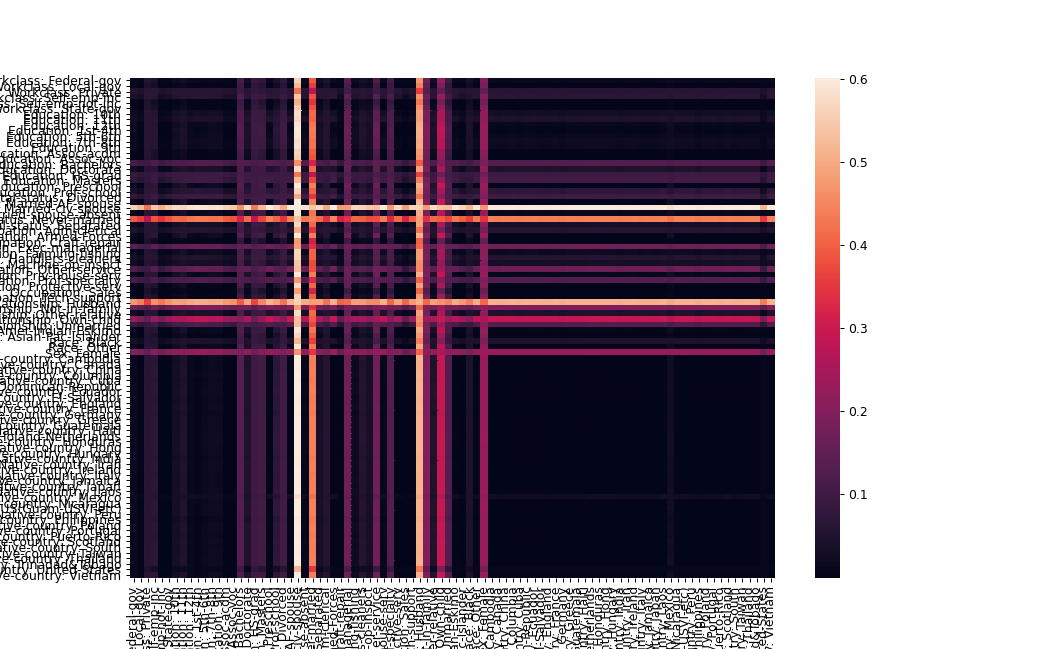

In [11]:
fig,ax = plt.subplots(1)
ax = sns.heatmap(rel_polarity_matrix, xticklabels=1, yticklabels=1,ax=ax)
plt.show()

By zooming in, we can identify (for example) that certain categories of the Marital-status variable exhibiting strong polarity with other variables (their categories). Perhaps as a variable itself, its univariate-polarity is high. Let us also explore a subset of the the data above as a graph:

<IPython.core.display.Javascript object>


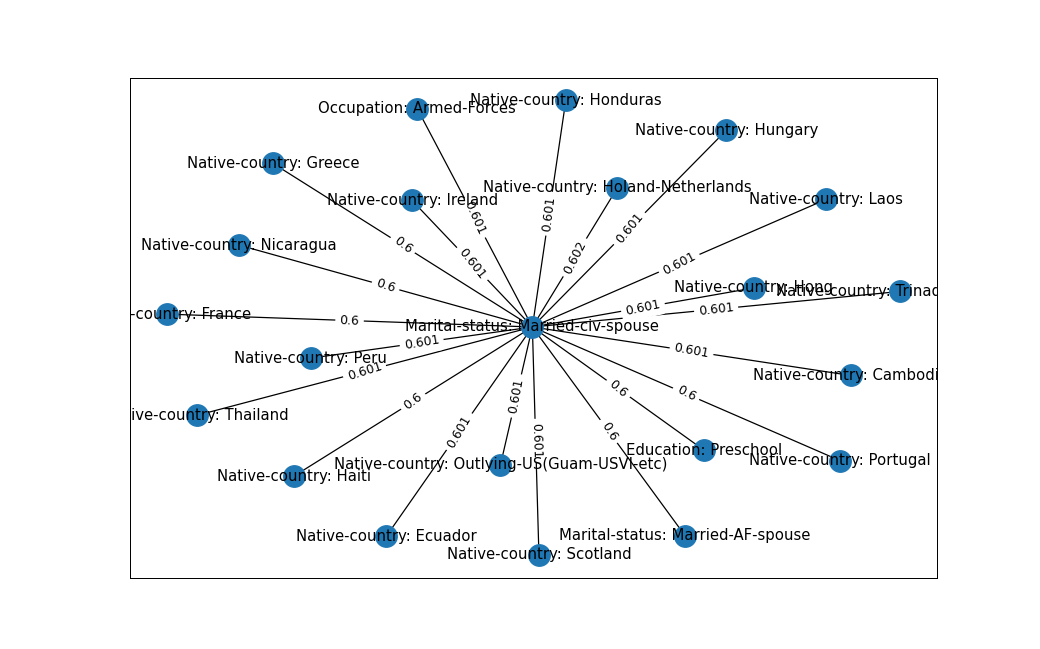

In [12]:
# plot polarity graph, using the thresh variable as a cut-off for strong polarity
thresh = 0.6
polarity_graph_vals = rel_polarity_matrix[rel_polarity_matrix > thresh].fillna(0)
polarity_graph_vals = polarity_graph_vals.round(3)

# remove diagonal entries, and remove variables with weak polarity
cols = polarity_graph_vals.columns
for c in cols: polarity_graph_vals[c][c] = 0
var_mask = (polarity_graph_vals.T != 0).any()
polarity_graph_vals = polarity_graph_vals[var_mask]
polarity_graph_vals = polarity_graph_vals.T[var_mask].T

polarity_graph_vals

corr_graph = nx.from_pandas_adjacency(polarity_graph_vals)

pos = nx.spring_layout(corr_graph)

fig, ax = plt.subplots(1)


nx.draw_networkx(corr_graph,pos,ax=ax)
weights = nx.get_edge_attributes(corr_graph, 'weight')
nx.draw_networkx_edge_labels(corr_graph,pos,edge_labels=weights)
plt.show()

These are quite high polarity values, and the decision to use 0.6 as the cut-off for the plot above was arbitrary.
It appears that the polarity is quite strong between particular categories of native-country and Marital-status. 

Other than the two plots above, we can also look at mosaic plots of every pair of variables (or bi-mekko plots, or qualitative mekko plots):

<IPython.core.display.Javascript object>


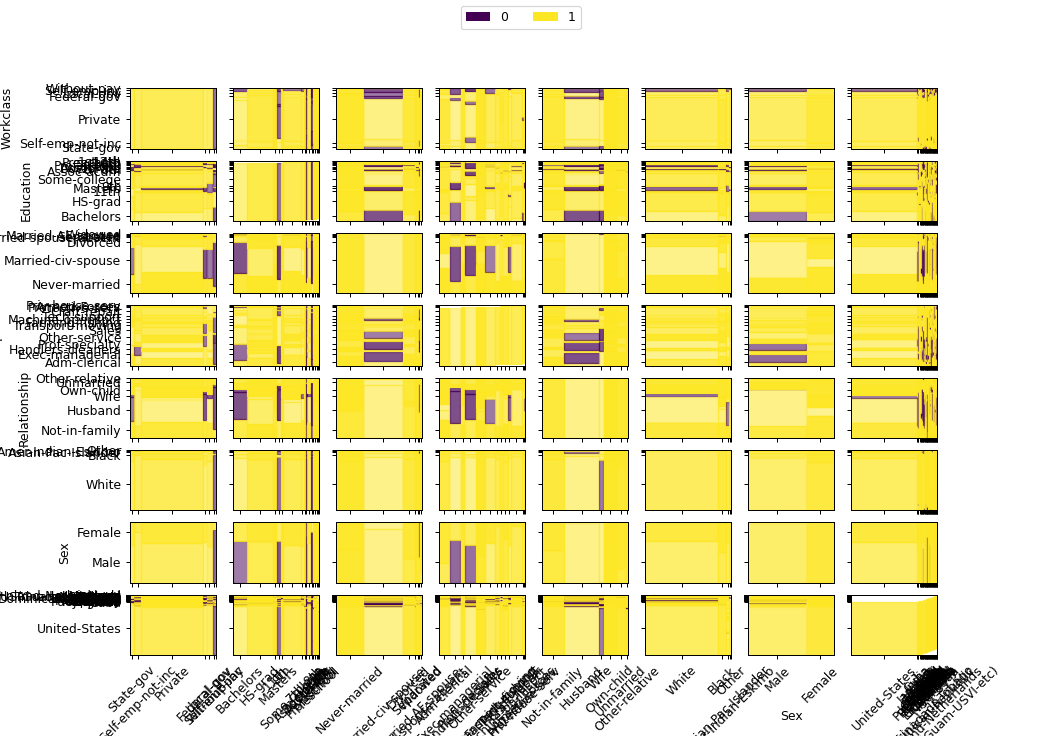

In [13]:
create_qualitative_mekko_charts(x_qual=df_qual.drop(columns=['Salary']),y_var=y_variable,share_y='row')
plt.show()

The plot above is the mosaic plot for each variable pairing, with the tiles having colors equal to the class (<= 50k or > 50k) they most represent - have a higher rel. freq for. The  *alpha* value of these colors are determined by such the corresponding rel. frequency. The color code is at the top of the plot, with 0 = > 50k, and 1 <= 50k.

Due to the size of the diagram, the x-labels (and ticks) are shared for each column. Since the width of the tiles are consistent throughout a column this isn't a problem. However, the y-labels and ticks are also shared for each row which is a problem since the height of the tiles are not consistent within every column of each row. This formatting was neccessary for readability.

What we can pull-out (by full-screening and zooming in) is for example that a married-civic-spouse (Relationship) who is either an exec, or in a prof-speciality (Occupation) is mostly earning > 50k. Likewise, for those who are wives or husbands or in an own-child (Relationship), and hold a masters, doctorate or attended a prof-school (Education).

We can study if the polarity graph above corresponded to the values above: 

<IPython.core.display.Javascript object>


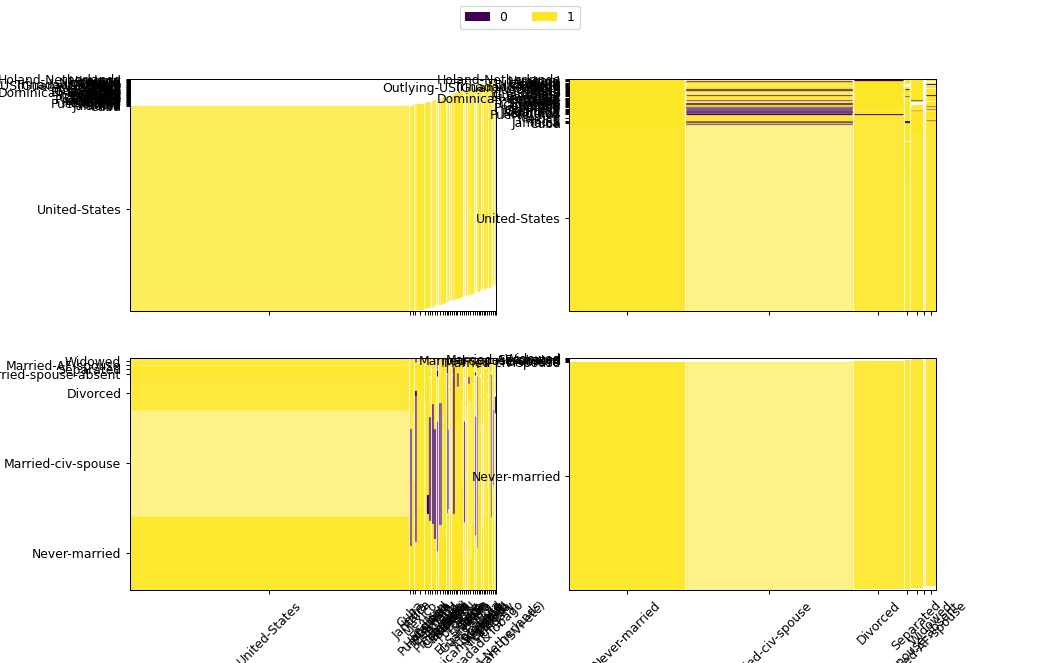

In [14]:
create_qualitative_mekko_charts(x_qual=df_qual[['Native-country','Marital-status']],y_var=y_variable,share_y=False)
plt.show()

By studying the lower-left subplot, it would appear that the polarity values do not coincide actually coincide strongly with the purple tiles above, suggesting either that polarity is not useful measure for qualitative variables or that it provides usefulness somewhat orthoganal to these plots.

## Exploring quantitative-qualitative relationships

We attempt class-seperation by plotting relationships between the quantitative (numerical) and the qualitative (categorical) variables. One manner of doing so is via stripplots:

### Stripplots (quantitative mekko charts)

<IPython.core.display.Javascript object>


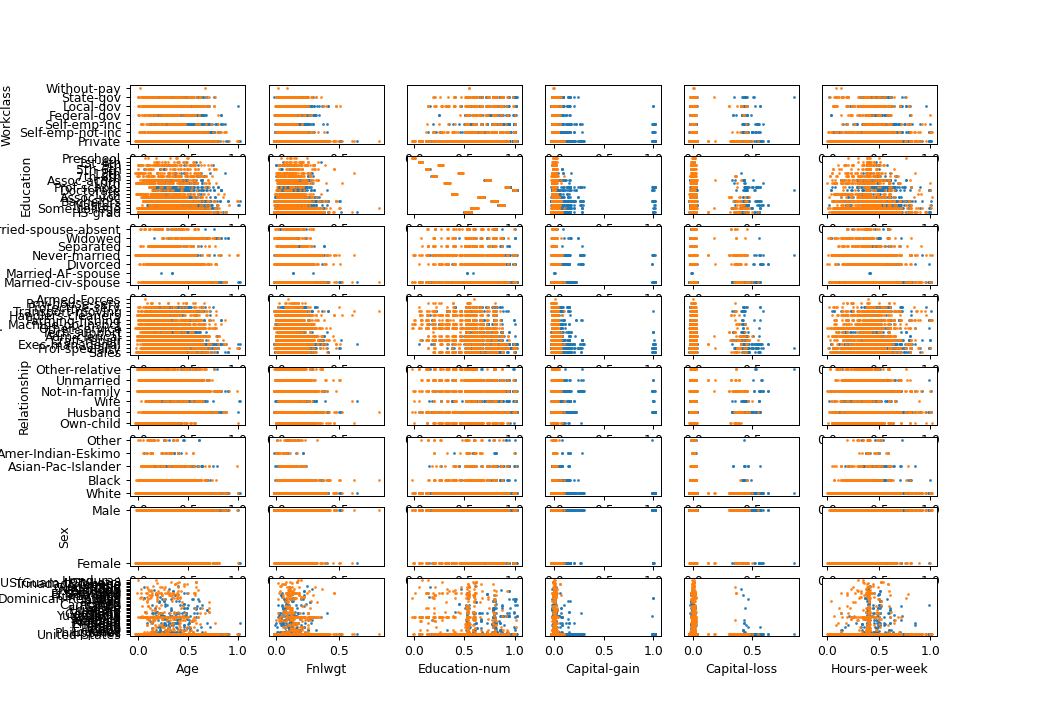

In [15]:
create_quantitative_mekko_charts(df_quant.copy(), df_qual.drop(columns=['Salary']).copy(), y_variable,
                                 num_samples=3000,hide_legend=True)

The blue plots above represent the (> 50k) class whilst the orange is for the (<= 50k) class. We see again that Capital-gain has a good seperation between the two classes (even though we are only partially sampling the dataset). Capital-loss also appears to have some level of seperation. Note that within the Education variable, the categories: Doctorate and Prof-School appear to be mostly >50k, although this could be due to sampling error. This can be checked simply by a relative frequency vector for the categories of each variable. Lastly, we find that a strong proportion of Doctorate holders and those that attended Prof-School earned >50k.

## Summary

All in all, we have found some potential variables for classification: Capital-gain, Capital-loss, Education, Relationship and Occupation. In the confirmatory analysis notebook, we will attempt both machine learning techniques for classification via decision trees, as well as a manual approach based on these variables identified.